In [2]:
# initialize libs
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

# torch libs
import torch
import torch.nn as nn 
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

# load data libs
import requests
import gzip
import os
import hashlib


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/erirosv/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# getting the data to train the model

def get_data(url):
    file_path = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open (file_path, 'rb') as f:
            data = f.read()
    else:
        with open(file_path, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

In [4]:
x_train = get_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

Constructing neural network model with torch

In [5]:
class ApexNet(torch.nn.Module):
    def __init__(self) -> None:
        """
        Initialize class with an constructor and parameters
        """
        super(ApexNet, self).__init__()
        self.linear_1 = nn.Linear(784, 128, bias=False)
        self.linear_2 = nn.Linear(128, 10, bias=False)
        self.soft_max = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass for the model
        """
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        s = self.soft_max(x)
        return x

Training the torch model

loss nan accuracy 0.094: 100%|██████████| 1000/1000 [00:01<00:00, 870.66it/s]                                     


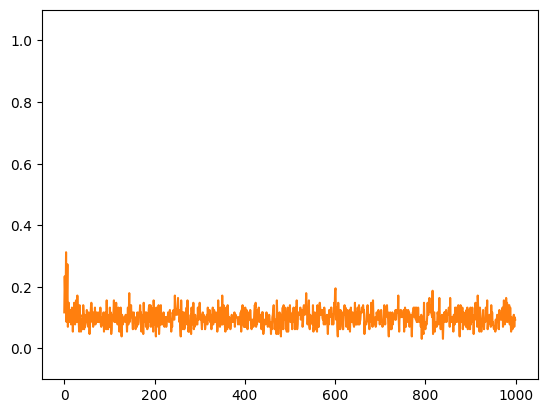

In [6]:
model = ApexNet()

# loss function
loss_funtion = nn.NLLLoss(reduction='none')
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# batch size
batch_size = 128

# empty lists for loss and accuracy
losses = []
accuracies = []

# loop to train the mdodel
for i in (t := trange(1000)):
    # creating a sample of random ints
    sample = np.random.randint(0, x_train.shape[0], size=(batch_size))
    
    # loading data into variable X and Y
    X = torch.tensor(x_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[sample]).long()
    
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)

    # getting the accuracy
    accuracy = (cat == Y).float().mean()

    # getting loss
    loss = loss_funtion(out, Y)
    loss = loss.mean()
    loss.backward()

    # optimizer
    optimizer.step()

    # getting loss and accuracy and appending them to list repectivly
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)

    # printing result
    t.set_description("loss %.3f accuracy %.3f" % (loss, accuracy))
    
# printing the data
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)
